<a href="https://colab.research.google.com/github/soohyunme/Foreigner_speech/blob/main/Code/Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference



https://blog.naver.com/sexyit_2019/221603292906

https://youdaeng-com.tistory.com/5

https://dacon.io/competitions/official/235738/codeshare/2902?page=1&dtype=recent

# 모듈 설치 및 로드

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display
from tqdm import tqdm
from glob import glob
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, TimeDistributed,\
 Dropout, Bidirectional, GRU, BatchNormalization, Activation,\
 LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

In [62]:
import tensorflow as tf
import os

try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
except:
  print('TPU device not found')

TPU device not found


In [63]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

GPU device not found


with tf.device('/device:GPU:0'):  
이후 모델 넣기  
https://m.blog.naver.com/demian7607/222043724449


# 경로 설정

In [64]:
cd /content/drive/MyDrive/foreigner_speech/dataset

/content/drive/MyDrive/foreigner_speech/dataset


In [65]:
DATA_DIR = './train/wav/'

# 데이터 로드

In [66]:
train_paths = glob("./train/wav/*.wav")
test_paths = glob("./test/*.wav")
label_df = pd.read_csv('./final_text.csv').iloc[:,[0,-1]]

In [67]:
# 데이터 형태 파악
# sr : 오디오의 초당 샘플링 수, wav : 시계열 데이터
wav, sr = librosa.load(train_paths[0])
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 22050
wav shape: (314433,)
length: 14.26 secs


# 함수 정의

In [68]:
def load_data(paths):
    result = []
    for path in tqdm(paths):
        # sr = n이 의미하는 것은 1초당 n개의 데이터를 샘플링 한다는 것입니다.
        data, sr = librosa.load(path, sr = 16000) # 사람 목소리는 대부분 16000Hz 안에 포함됨
        result.append(data)
    result = np.array(result)
    # 메모리가 부족할 때는 데이터 타입을 변경해 주세요 ex) np.array(data, dtype = np.float32)

    return result

In [69]:
def get_mini(data):

    mini = 9999999
    for i in data:
        if len(i) < mini:
            mini = len(i)

    return mini

#음성들의 길이를 맞춰줍니다.

In [70]:
def set_length(data, d_mini):

    result = []
    for value in tqdm(data):
        value = value[:d_mini]
        if len(value)<d_mini:
            value = np.append(value, [0]*(d_mini-len(value)))
        result.append(value)
    result = np.array(result)

    return result

In [71]:
def get_feature(data, sr = 16000, n_mfcc = 100, n_fft = 2048, win_length = 200, hop_length = 160):
    mfcc = []
    for i in tqdm(data):
        # n_mfcc 는 return 될 mfcc의 개수 default = 20
        # n_fft 는 frame의 length를 결정하는 파라미터, window size가 자동으로 같은 값으로 설정
        # window size의 크기로 잘린 음성이 n_fft보다 작은 경우 0으로 padding을 붙여주는 
        # 작업을 하기 때문에 n_fft는 window size보다 크거나 같아야 함
        # win_length 는 음성을 작은 조각으로 자를때 작은 조각의 크기입니다.
        # hop_length 는 음성을 작은 조각으로 자를때 자르는 간격을 의미합니다.
        mfcc_ = librosa.feature.mfcc(i, sr=sr, n_mfcc = n_mfcc, n_fft = n_fft,win_length = win_length, hop_length = hop_length)
        mfcc.append(mfcc_)
    mfcc = np.array(mfcc)
    
#     Standardization
#     mfcc_mean = mfcc.mean()
#     mfcc_std = mfcc.std()
#     mfcc = (mfcc - mfcc_mean) / mfcc_std

    return mfcc

# 전처리

## Numpy 변환

In [72]:
# # npy 파일로 저장
# try :
#   os.mkdir('./npy_data')
# except:
#   print('Directory  exists')
# train_data = load_data(train_paths)
# np.save('./npy_data/train.npy',train_data)

# test_data = load_data(test_paths)
# np.save('./npy_data/test.npy',test_data)

In [73]:
# npy 불러오기
train_x = np.load('./npy_data/train.npy',allow_pickle=True)
test_x = np.load('./npy_data/test.npy',allow_pickle=True)

## MFCC

In [74]:
# 음성의 길이 중 가장 작은 길이를 구합니다.

train_mini = get_mini(train_x)
test_mini = get_mini(test_x)

mini = np.min([train_mini, test_mini])

In [75]:
# data의 길이를 가장 작은 길이에 맞춰 잘라줍니다.

split_train_x = set_length(train_x, mini)
split_test_x = set_length(test_x, mini)


100%|██████████| 10/10 [00:00<00:00, 13560.63it/s]


In [76]:
# librosa를 이용해 mfcc feature를 추출합니다.
train_feature_x = get_feature(data = split_train_x)
test_feature_x = get_feature(data = split_test_x)


100%|██████████| 10/10 [00:00<00:00, 18.29it/s]


[Text(0.5, 1.0, 'MFCC')]

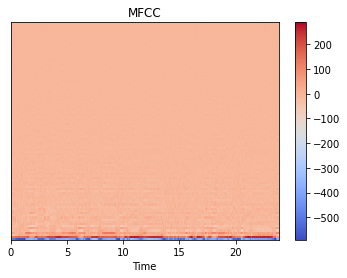

In [77]:
# MFCC display
fig, ax = plt.subplots()
img = librosa.display.specshow(train_feature_x[0], sr=16000, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

## train test split

In [78]:
# 임의로 train test 분리
# Train : CN11RC001 ~ CN11RC024
# Test : CN11RC025

X_train = train_feature_x[:2454]
X_test = train_feature_x[2454:2580]

y_train =label_df.iloc[:2454][['ReadingTarget']]
y_test =label_df.iloc[2454:2580][['ReadingTarget']]

In [79]:
# Train, Test shape 확인
X_train.shape, X_test.shape

((2454, 100, 744), (126, 100, 744))

In [80]:
X_train_ex = np.expand_dims(X_train,-1)
X_test_ex = np.expand_dims(X_test,-1)
X_train_ex.shape

(2454, 100, 744, 1)

# Modeling

In [81]:
model = tf.keras.models.Sequential()
model.add(Input(shape=X_train_ex[0].shape))

model.add(Conv2D(64, kernel_size=(4,4), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))

#model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 97, 741, 64)       1088      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 185, 64)      0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 284160)            0         
                                                                 
 dense_14 (Dense)            (None, 32)                9093152   
                                                                 
 dense_15 (Dense)            (None, 10)                330       
                                                                 
Total params: 9,094,570
Trainable params: 9,094,570
Non-trainable params: 0
____________________________________________